# Colorectal histology dataset with LeNet 5

# Preview: Neural Network examples with `tf.keras`

- `tf.keras` Software (http://keras.io/);

- Visual example of LeNet-5 (http://yann.lecun.com/exdb/lenet/) using MNIST digits dataset;

- Examples with common neural network topologies (https://machinelearningmastery.com/tensorflow-tutorial-deep-learning-with-tf-keras/).

## Colorectal histology

Methods to diagnose colorectal using histology images (<https://zenodo.org/record/53169#.XGZemKwzbmG>, <https://www.tensorflow.org/datasets/catalog/colorectal_histology>)

In this case, the purpose is to classify the type of histology in a given image in the following categories:

- 0: TUMOR
- 1: STROMA
- 2: COMPLEX
- 3: LYMPHO
- 4: DEBRIS
- 5: MUCOSA
- 6: ADIPOSE
- 7: EMPTY

## Local instalation (option 1)

Install the following Python packages to run this notebook

`pip install pip -U`

`pip install tensorflow jupyter`

## Google Colab (option 2)

[Google Colab](https://colab.research.google.com/) is a research project created to help disseminate machine learning education and research. It's a `Jupyter notebook` environment that requires no setup to use and runs entirely in the cloud.

Colaboratory notebooks are stored in [Google Drive](https://drive.google.com) and can be shared just as you would with Google Docs or Sheets. Colaboratory is free to use.

For more information, see our [FAQ](https://research.google.com/colaboratory/faq.html).

### How install extra packages
Google Colab installs a series of basic packages if we need any additional package just install it.

In [ ]:
!pip install -q keras sklearn

## Import packages

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import collections

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

## Define global constants

Lets start with a few epochs to test learning network parameters

In [35]:
#Function to set the number of epochs and batches
def set_epochs_batches(epochs_number , batches ): 
  epochs= epochs_number
  batch_size = batches
  return 

In [36]:
batch_size = 34 #Number of training examples
nb_classes = 2  #or 8
epochs = 5 #Number of iterations // Passes the entire training has completed
# Scaling input image to theses dimensions
img_rows, img_cols = 32, 32

## Load image database

In [4]:
def format_example(image):
    image = tf.cast(image, tf.float32)
    # Normalize the pixel values
    image = image / 255.0
    # Resize the image
    image = tf.image.resize(image, (img_rows, img_cols))
    return image


def load_data(name="colorectal_histology"):
  train_ds = tfds.load(name, split=tfds.Split.TRAIN, batch_size=-1)
  train_ds['image'] = tf.map_fn(format_example, train_ds['image'], dtype=tf.float32)
  numpy_ds = tfds.as_numpy(train_ds)
  X, y = numpy_ds['image'], numpy_ds['label']

  return np.array(X), np.array(y)

## Plot images

In [5]:
def plot_symbols(X,y,n=15):
    index = np.random.randint(len(y), size=n)
    plt.figure(figsize=(25, 2))
    for i in np.arange(n):
        ax = plt.subplot(1,n,i+1)
        plt.imshow(X[index[i],:,:,:])
        plt.gray()
        ax.set_title(f'{y[index[i]]}-{index[i]}')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

## Build LeNet5 structure

<center><img src="https://www.dlsi.ua.es/~juanra/UA/curso_verano_DL/images/LeNet5.jpg"></center>

In [50]:
#
# Build an ANN structure - LeNet5
#
# The model will receive the activation functions
def cnn_model(activation_functions):
    #
    # Neural Network Structure
    #
    
    model = Sequential()
    
    
    model.add(layers.Conv2D(6, (5, 5))) #Output dimensionality, kernel_size (Height, width)
    model.add(layers.Activation(activation_functions[0])) #Applies an activation function to an output
    model.add(layers.MaxPooling2D(pool_size=(2, 2))) #Getting a size 2x2 for the window
    
    model.add(layers.Conv2D(16, (5, 5)))
    model.add(layers.Activation(activation_functions[1]))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        
    model.add(layers.Flatten())
    
    model.add(layers.Dense(120)) #dense(Dimensionality of the output space)
    model.add(layers.Activation(activation_functions[2]))
    
    model.add(layers.Dense(84))
    model.add(layers.Activation(activation_functions[3]))
    
    model.add(layers.Dense(nb_classes))
    model.add(layers.Activation(activation_functions[4]))

    return model

## Start to run the program

### Load data

In [7]:
##################################################################################
# Main program

X, y = load_data()
print("Los resultados que hemos obtenido, son los siguientes")

print(X.shape, 'train samples')
print(img_rows,'x', img_cols, 'image size')
print(epochs,'epochs')

Shuffling and writing examples to /root/tensorflow_datasets/colorectal_histology/2.0.0.incomplete2ZNX0R/colorectal_histology-train.tfrecord


Dataset colorectal_histology downloaded and prepared to /root/tensorflow_datasets/colorectal_histology/2.0.0. Subsequent calls will reuse this data.
Los resultados que hemos obtenido, son los siguientes
(5000, 32, 32, 3) train samples
32 x 32 image size
5 epochs


Only for binary classification. All number of classes greater than 0 will be set to 1.

In [9]:
if nb_classes==2:
  y[y>0] = 1

### Let to see examples of the dataset

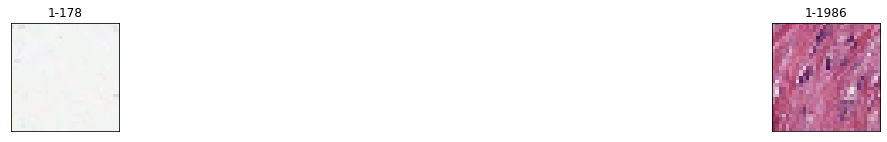

In [43]:
plot_symbols(X, y, 2)

## Number of examples per class

In [42]:
collections.Counter(y)

Counter({0: 625, 1: 4375})

## Split examples in training/test sets

#Fucntion to create some models with different epochs in order to compare each other and get the best one

In [94]:
#Vamos a ir lanzando varios modelos, creando un array de acc, y el que mejor resultados nos dé, es con el que nos vamos a quedar
def create_models_arrays_comparison(model_i):
  #Primero, cambiaremos las funciones de activación
  activation_functions = []
  activation_functions.append(["tanh", "tanh", "tanh", "tanh", "softmax"] )
  activation_functions.append(["sigmoid", "sigmoid" , "sigmoid", "sigmoid" , "softmax"])
  activation_functions.append( ["relu", "relu", "relu", "relu", "softmax"])
  activation_functions.append( ["tanh", "tanh", "tanh", "tanh", "relu"])
  activation_functions.append( ["sigmoid", "sigmoid", "sigmoid", "sigmoid", "relu"])
  activation_functions.append( ["relu", "relu", "relu", "relu", "relu"])
  optimizers = ['adam' , 'sgd' , 'adadelta'] 
  augmentation = [True, False]
  best = 0
  best_optimizer = ''
  with_data_augmentation = False
  best_function = []
  best_epoch_number = 0
  best_batch_number = 0
  
  if model_i == 0: 
    #Iremos cambiando las épocas para cada uno de ellos (Épocas: de 5 a 15 ) 
    #También cambiaremos el número de batches (20 - 40)
    for activation_function in activation_functions: 
      for epoch_i  in range(5,15): 
        for batch_i in range(20,40):
          for optimizer_i in optimizers:
            for augmentation_i in augmentation: 
              set_epochs_batches(epoch_i , batch_i ) 
              #Getting the result
              acc_per_fold, loss_per_fold, auc_per_fold, y_pred, acc_percent_per_fold, model = cross_validation(10 , activation_function , optimizer_i , augmentation_i  )
              plt.plot(range(len( acc_percent_per_fold)) , acc_percent_per_fold , 'ro-',label=activation_function[0] + ", " +  activation_function[4] + " [ " + epoch_i + ", " + batch_i + ", " + optimizer_i + ", " + augmentation_i  +" ]")
              #Getting the media_value
              total = 0
              for value in acc_per_fold: 
                total = total + value
              media_value = total/len(acc_per_fold)
              if media_value > best: 
                best = media_value
                best_function = activation_function
                best_epoch_number = epoch_i
                best_batch_number = batch_i
                best_optimizer =optimizer_i
                with_data_augmentation = augmentation_i
    
    print("THE BEST MODEL IS " + bect_function )
    print("WITH A EPOCH_NUMBER OF " + best_epoch_number + " AND A BATCH SIZE OF " + best_batch_number )
    print("AND WITH THE OPTIMIZER " + best_optimizer)
    print("AND WITH DATA_AUGMENTATION "  + with_data_augmentation )
    plt.ylabel('Aciertos')
    plt.xlabel('Fold')
    plt.legend()
    return

  if model_i == 1:  
    set_epochs_batches(5,34 ) #Probamos cuál es el mejor modelo con las mismas épocas y batches
    best_epoch = 5
    best_batch_number= 34

    #Pondremos el optimizador de adam
    for activation_function in activation_functions: 
      acc_per_fold, loss_per_fold, auc_per_fold, y_pred, acc_percent_per_fold, model = cross_validation(10 , activation_function , "adam" , False)
      plt.plot(range(len( acc_percent_per_fold)) , acc_percent_per_fold , 'bs-',label=activation_function[0] + ", " +  activation_function[4] )
      #Getting the media_value
      total = 0
      for value in acc_per_fold: 
        total = total + value
      media_value = total/len(acc_per_fold)
      if media_value > best: 
        best = media_value
        best_function = activation_function
        with_data_augmentation = False

    print("FIRST MODEL GRAPHIC")
    plt.ylabel('Aciertos')
    plt.xlabel('Fold')
    plt.legend()
    
    #Once we have the result, we create another loop in order to get the best epoch and batch model
    for epoch_i  in range(5,15): 
      for batch_i in range(20,40):
        for optimizer_i in optimizers:
          for augmentation_i in augmentation: 
            set_epochs_batches(epoch_i , batch_i ) 
            #Getting the result
            acc_per_fold, loss_per_fold, auc_per_fold, y_pred, acc_percent_per_fold, model = cross_validation(10 , best_function , optimizer_i , augmentation_i  )
            plt.plot(range(len( acc_percent_per_fold)) , acc_percent_per_fold , 'ro-',label=activation_function[0] + ", " +  activation_function[4] + " [ " + epoch_i + ", " + batch_i + ", " + optimizer_i + ", " + augmentation_i  +" ]")
            #Getting the media_value
            total = 0
            for value in acc_per_fold: 
              total = total + value
            media_value = total/len(acc_per_fold)
            if media_value > best: 
              best = media_value
              best_epoch_number = epoch_i
              best_batch_number = batch_i
              best_optimizer =optimizer_i
              with_data_augmentation = augmentation_i 
    
    print("THE BEST MODEL IS " + bect_function )
    print("WITH A EPOCH_NUMBER OF " + best_epoch_number + " AND A BATCH SIZE OF " + best_batch_number )
    print("AND WITH THE OPTIMIZER " + best_optimizer)
    print("AND WITH DATA_AUGMENTATION "  + with_data_augmentation )
    print("FIRST MODEL GRAPHIC")
    plt.ylabel('Aciertos')
    plt.xlabel('Fold')
    plt.legend()
 
  return


In [ ]:
create_models_arrays_comparison(1)

Before  563
The old size was  563
The new size is  3941
After  3941
X_train (7878, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7878,) y_test (500,)
y_train_nn (7878, 2) y_test_nn (500, 2)
209/209 - 1s - loss: 0.2189 - accuracy: 0.9016 - val_loss: 0.0060 - val_accuracy: 1.0000
15/15 [==============================] - 0s 2ms/step - loss: 0.2295 - accuracy: 0.8960
loss: 0.23 acc: 0.90
Predictions Counter({1: 472, 0: 28}) 

Confusion matrix
[[ 19  43]
 [  9 429]] 

              precision    recall  f1-score   support

       TUMOR       0.68      0.31      0.42        62
     HEALTHY       0.91      0.98      0.94       438

    accuracy                           0.90       500
   macro avg       0.79      0.64      0.68       500
weighted avg       0.88      0.90      0.88       500

AUC 0.9155 
Before  563
The old size was  563
The new size is  3941
After  3941
X_train (7878, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7878,) y_test (500,)
y_train_nn (7878, 2) y_test_nn (500, 2)
209/209

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3941
After  3941
X_train (7878, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7878,) y_test (500,)
y_train_nn (7878, 2) y_test_nn (500, 2)
209/209 - 1s - loss: 7.1398 - accuracy: 0.5546 - val_loss: 16.1181 - val_accuracy: 0.0000e+00
15/15 [==============================] - 0s 2ms/step - loss: 1.9986 - accuracy: 0.8760
loss: 2.00 acc: 0.88
Predictions Counter({1: 500}) 

Confusion matrix
[[  0  62]
 [  0 438]] 

              precision    recall  f1-score   support

       TUMOR       0.00      0.00      0.00        62
     HEALTHY       0.88      1.00      0.93       438

    accuracy                           0.88       500
   macro avg       0.44      0.50      0.47       500
weighted avg       0.77      0.88      0.82       500

AUC 0.8652 
Before  563
The old size was  563


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3941
After  3941
X_train (7878, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7878,) y_test (500,)
y_train_nn (7878, 2) y_test_nn (500, 2)
209/209 - 1s - loss: 0.0341 - accuracy: 0.4454 - val_loss: 1.1921e-07 - val_accuracy: 1.0000
15/15 [==============================] - 0s 2ms/step - loss: 0.0322 - accuracy: 0.1300
loss: 0.03 acc: 0.13
Predictions Counter({0: 495, 1: 5}) 

Confusion matrix
[[ 61   1]
 [434   4]] 

              precision    recall  f1-score   support

       TUMOR       0.12      0.98      0.22        62
     HEALTHY       0.80      0.01      0.02       438

    accuracy                           0.13       500
   macro avg       0.46      0.50      0.12       500
weighted avg       0.72      0.13      0.04       500

AUC 0.4966 
Before  563
The old size was  563
The new size is  3941
After  3941
X_train (7878, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7878,) y_test (500,)
y_train_nn (7878, 2) y_test_nn (500, 2)
209/209 - 1s - loss: 0.1592 - accuracy

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3941
After  3941
X_train (7878, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7878,) y_test (500,)
y_train_nn (7878, 2) y_test_nn (500, 2)
209/209 - 1s - loss: 6.5748 - accuracy: 0.5711 - val_loss: 16.1181 - val_accuracy: 0.0000e+00
15/15 [==============================] - 0s 2ms/step - loss: 1.9986 - accuracy: 0.8760
loss: 2.00 acc: 0.88
Predictions Counter({1: 500}) 

Confusion matrix
[[  0  62]
 [  0 438]] 

              precision    recall  f1-score   support

       TUMOR       0.00      0.00      0.00        62
     HEALTHY       0.88      1.00      0.93       438

    accuracy                           0.88       500
   macro avg       0.44      0.50      0.47       500
weighted avg       0.77      0.88      0.82       500

AUC 0.8568 
Before  562
The old size was  562


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3934
After  3934
X_train (7872, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7872,) y_test (500,)
y_train_nn (7872, 2) y_test_nn (500, 2)
209/209 - 1s - loss: 7.1580 - accuracy: 0.5559 - val_loss: 16.1181 - val_accuracy: 0.0000e+00
15/15 [==============================] - 0s 2ms/step - loss: 2.0309 - accuracy: 0.8740
loss: 2.03 acc: 0.87
Predictions Counter({1: 500}) 

Confusion matrix
[[  0  63]
 [  0 437]] 

              precision    recall  f1-score   support

       TUMOR       0.00      0.00      0.00        63
     HEALTHY       0.87      1.00      0.93       437

    accuracy                           0.87       500
   macro avg       0.44      0.50      0.47       500
weighted avg       0.76      0.87      0.82       500

AUC 0.3543 
Before  562
The old size was  562


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3934
After  3934
X_train (7872, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7872,) y_test (500,)
y_train_nn (7872, 2) y_test_nn (500, 2)
209/209 - 1s - loss: 6.1145 - accuracy: 0.4627 - val_loss: 16.1181 - val_accuracy: 0.0000e+00
15/15 [==============================] - 0s 2ms/step - loss: 0.9026 - accuracy: 0.6860
loss: 0.90 acc: 0.69
Predictions Counter({1: 336, 0: 164}) 

Confusion matrix
[[ 35  28]
 [129 308]] 

              precision    recall  f1-score   support

       TUMOR       0.21      0.56      0.31        63
     HEALTHY       0.92      0.70      0.80       437

    accuracy                           0.69       500
   macro avg       0.57      0.63      0.55       500
weighted avg       0.83      0.69      0.74       500

AUC 0.7313 
Before  562
The old size was  562
The new size is  3934
After  3934
X_train (7872, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7872,) y_test (500,)
y_train_nn (7872, 2) y_test_nn (500, 2)
209/209 - 1s - loss: 8.5187 - accur

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3934
After  3934
X_train (7872, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7872,) y_test (500,)
y_train_nn (7872, 2) y_test_nn (500, 2)
209/209 - 1s - loss: 7.1536 - accuracy: 0.5497 - val_loss: 16.1181 - val_accuracy: 0.0000e+00
15/15 [==============================] - 0s 2ms/step - loss: 2.0309 - accuracy: 0.8740
loss: 2.03 acc: 0.87
Predictions Counter({1: 500}) 

Confusion matrix
[[  0  63]
 [  0 437]] 

              precision    recall  f1-score   support

       TUMOR       0.00      0.00      0.00        63
     HEALTHY       0.87      1.00      0.93       437

    accuracy                           0.87       500
   macro avg       0.44      0.50      0.47       500
weighted avg       0.76      0.87      0.82       500

AUC 0.7757 
Before  562
The old size was  562


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3934
After  3934
X_train (7872, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7872,) y_test (500,)
y_train_nn (7872, 2) y_test_nn (500, 2)
209/209 - 1s - loss: 2.0296 - accuracy: 0.7657 - val_loss: 1.1921e-07 - val_accuracy: 1.0000
15/15 [==============================] - 0s 2ms/step - loss: 0.7659 - accuracy: 0.7780
loss: 0.77 acc: 0.78
Predictions Counter({1: 448, 0: 52}) 

Confusion matrix
[[  2  61]
 [ 50 387]] 

              precision    recall  f1-score   support

       TUMOR       0.04      0.03      0.03        63
     HEALTHY       0.86      0.89      0.87       437

    accuracy                           0.78       500
   macro avg       0.45      0.46      0.45       500
weighted avg       0.76      0.78      0.77       500

AUC 0.6498 
Before  563
The old size was  563
The new size is  3941
After  3941
X_train (7878, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7878,) y_test (500,)
y_train_nn (7878, 2) y_test_nn (500, 2)
209/209 - 1s - loss: 7.1679 - accurac

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3941
After  3941
X_train (7878, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7878,) y_test (500,)
y_train_nn (7878, 2) y_test_nn (500, 2)
209/209 - 1s - loss: 7.1679 - accuracy: 0.5553 - val_loss: 16.1181 - val_accuracy: 0.0000e+00
15/15 [==============================] - 0s 2ms/step - loss: 1.9986 - accuracy: 0.8760
loss: 2.00 acc: 0.88
Predictions Counter({1: 500}) 

Confusion matrix
[[  0  62]
 [  0 438]] 

              precision    recall  f1-score   support

       TUMOR       0.00      0.00      0.00        62
     HEALTHY       0.88      1.00      0.93       438

    accuracy                           0.88       500
   macro avg       0.44      0.50      0.47       500
weighted avg       0.77      0.88      0.82       500

AUC 0.5000 
Before  563
The old size was  563


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3941
After  3941
X_train (7878, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7878,) y_test (500,)
y_train_nn (7878, 2) y_test_nn (500, 2)
209/209 - 1s - loss: 7.1679 - accuracy: 0.5553 - val_loss: 16.1181 - val_accuracy: 0.0000e+00
15/15 [==============================] - 0s 2ms/step - loss: 1.9986 - accuracy: 0.8760
loss: 2.00 acc: 0.88
Predictions Counter({1: 500}) 

Confusion matrix
[[  0  62]
 [  0 438]] 

              precision    recall  f1-score   support

       TUMOR       0.00      0.00      0.00        62
     HEALTHY       0.88      1.00      0.93       438

    accuracy                           0.88       500
   macro avg       0.44      0.50      0.47       500
weighted avg       0.77      0.88      0.82       500

AUC 0.5000 
Before  563
The old size was  563


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3941
After  3941
X_train (7878, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7878,) y_test (500,)
y_train_nn (7878, 2) y_test_nn (500, 2)
209/209 - 1s - loss: 1.1921e-07 - accuracy: 0.4447 - val_loss: 1.1921e-07 - val_accuracy: 1.0000
15/15 [==============================] - 0s 2ms/step - loss: 1.1921e-07 - accuracy: 0.1240
loss: 0.00 acc: 0.12
Predictions Counter({0: 500}) 

Confusion matrix
[[ 62   0]
 [438   0]] 

              precision    recall  f1-score   support

       TUMOR       0.12      1.00      0.22        62
     HEALTHY       0.00      0.00      0.00       438

    accuracy                           0.12       500
   macro avg       0.06      0.50      0.11       500
weighted avg       0.02      0.12      0.03       500

AUC 0.5000 
Before  563
The old size was  563


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3941
After  3941
X_train (7878, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7878,) y_test (500,)
y_train_nn (7878, 2) y_test_nn (500, 2)
209/209 - 1s - loss: 7.1679 - accuracy: 0.5553 - val_loss: 16.1181 - val_accuracy: 0.0000e+00
15/15 [==============================] - 0s 2ms/step - loss: 1.9986 - accuracy: 0.8760
loss: 2.00 acc: 0.88
Predictions Counter({1: 500}) 

Confusion matrix
[[  0  62]
 [  0 438]] 

              precision    recall  f1-score   support

       TUMOR       0.00      0.00      0.00        62
     HEALTHY       0.88      1.00      0.93       438

    accuracy                           0.88       500
   macro avg       0.44      0.50      0.47       500
weighted avg       0.77      0.88      0.82       500

AUC 0.5081 
Before  562
The old size was  562


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3934
After  3934
X_train (7872, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7872,) y_test (500,)
y_train_nn (7872, 2) y_test_nn (500, 2)
209/209 - 1s - loss: 0.6892 - accuracy: 0.5514 - val_loss: 0.8848 - val_accuracy: 0.0000e+00
15/15 [==============================] - 0s 3ms/step - loss: 0.5565 - accuracy: 0.8740
loss: 0.56 acc: 0.87
Predictions Counter({1: 500}) 

Confusion matrix
[[  0  63]
 [  0 437]] 

              precision    recall  f1-score   support

       TUMOR       0.00      0.00      0.00        63
     HEALTHY       0.87      1.00      0.93       437

    accuracy                           0.87       500
   macro avg       0.44      0.50      0.47       500
weighted avg       0.76      0.87      0.82       500

AUC 0.8212 
Before  562
The old size was  562


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3934
After  3934
X_train (7872, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7872,) y_test (500,)
y_train_nn (7872, 2) y_test_nn (500, 2)
209/209 - 1s - loss: 0.6529 - accuracy: 0.6231 - val_loss: 0.9388 - val_accuracy: 0.0000e+00
15/15 [==============================] - 0s 2ms/step - loss: 1.2576 - accuracy: 0.8280
loss: 1.26 acc: 0.83
Predictions Counter({1: 445, 0: 55}) 

Confusion matrix
[[ 16  47]
 [ 39 398]] 

              precision    recall  f1-score   support

       TUMOR       0.29      0.25      0.27        63
     HEALTHY       0.89      0.91      0.90       437

    accuracy                           0.83       500
   macro avg       0.59      0.58      0.59       500
weighted avg       0.82      0.83      0.82       500

AUC 0.7864 
Before  562
The old size was  562
The new size is  3934
After  3934
X_train (7872, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7872,) y_test (500,)
y_train_nn (7872, 2) y_test_nn (500, 2)
209/209 - 1s - loss: 7.1580 - accurac

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3934
After  3934
X_train (7872, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7872,) y_test (500,)
y_train_nn (7872, 2) y_test_nn (500, 2)
209/209 - 1s - loss: 7.1580 - accuracy: 0.5559 - val_loss: 16.1181 - val_accuracy: 0.0000e+00
15/15 [==============================] - 0s 2ms/step - loss: 2.0309 - accuracy: 0.8740
loss: 2.03 acc: 0.87
Predictions Counter({1: 500}) 

Confusion matrix
[[  0  63]
 [  0 437]] 

              precision    recall  f1-score   support

       TUMOR       0.00      0.00      0.00        63
     HEALTHY       0.87      1.00      0.93       437

    accuracy                           0.87       500
   macro avg       0.44      0.50      0.47       500
weighted avg       0.76      0.87      0.82       500

AUC 0.5215 
Before  562
The old size was  562


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3934
After  3934
X_train (7872, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7872,) y_test (500,)
y_train_nn (7872, 2) y_test_nn (500, 2)
209/209 - 1s - loss: 7.1580 - accuracy: 0.5559 - val_loss: 16.1181 - val_accuracy: 0.0000e+00
15/15 [==============================] - 0s 2ms/step - loss: 2.0309 - accuracy: 0.8740
loss: 2.03 acc: 0.87
Predictions Counter({1: 500}) 

Confusion matrix
[[  0  63]
 [  0 437]] 

              precision    recall  f1-score   support

       TUMOR       0.00      0.00      0.00        63
     HEALTHY       0.87      1.00      0.93       437

    accuracy                           0.87       500
   macro avg       0.44      0.50      0.47       500
weighted avg       0.76      0.87      0.82       500

AUC 0.5000 
Before  563
The old size was  563


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3941
After  3941
X_train (7878, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7878,) y_test (500,)
y_train_nn (7878, 2) y_test_nn (500, 2)
209/209 - 1s - loss: 0.1910 - accuracy: 0.4661 - val_loss: 1.1921e-07 - val_accuracy: 1.0000
15/15 [==============================] - 0s 2ms/step - loss: 0.2579 - accuracy: 0.1560
loss: 0.26 acc: 0.16
Predictions Counter({0: 468, 1: 32}) 

Confusion matrix
[[ 54   8]
 [414  24]] 

              precision    recall  f1-score   support

       TUMOR       0.12      0.87      0.20        62
     HEALTHY       0.75      0.05      0.10       438

    accuracy                           0.16       500
   macro avg       0.43      0.46      0.15       500
weighted avg       0.67      0.16      0.11       500

AUC 0.4567 
Before  563
The old size was  563
The new size is  3941
After  3941
X_train (7878, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7878,) y_test (500,)
y_train_nn (7878, 2) y_test_nn (500, 2)
209/209 - 1s - loss: 7.1679 - accurac

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3941
After  3941
X_train (7878, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7878,) y_test (500,)
y_train_nn (7878, 2) y_test_nn (500, 2)
209/209 - 1s - loss: 7.1687 - accuracy: 0.5547 - val_loss: 16.1181 - val_accuracy: 0.0000e+00
15/15 [==============================] - 0s 2ms/step - loss: 1.9986 - accuracy: 0.8760
loss: 2.00 acc: 0.88
Predictions Counter({1: 500}) 

Confusion matrix
[[  0  62]
 [  0 438]] 

              precision    recall  f1-score   support

       TUMOR       0.00      0.00      0.00        62
     HEALTHY       0.88      1.00      0.93       438

    accuracy                           0.88       500
   macro avg       0.44      0.50      0.47       500
weighted avg       0.77      0.88      0.82       500

AUC 0.8564 
Before  563
The old size was  563


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3941
After  3941
X_train (7878, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7878,) y_test (500,)
y_train_nn (7878, 2) y_test_nn (500, 2)
209/209 - 1s - loss: 1.2483 - accuracy: 0.9052 - val_loss: 1.1921e-07 - val_accuracy: 1.0000
15/15 [==============================] - 0s 2ms/step - loss: 1.9342 - accuracy: 0.8800
loss: 1.93 acc: 0.88
Predictions Counter({1: 498, 0: 2}) 

Confusion matrix
[[  2  60]
 [  0 438]] 

              precision    recall  f1-score   support

       TUMOR       1.00      0.03      0.06        62
     HEALTHY       0.88      1.00      0.94       438

    accuracy                           0.88       500
   macro avg       0.94      0.52      0.50       500
weighted avg       0.89      0.88      0.83       500

AUC 0.8246 
Before  563
The old size was  563
The new size is  3941
After  3941
X_train (7878, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7878,) y_test (500,)
y_train_nn (7878, 2) y_test_nn (500, 2)
209/209 - 1s - loss: 0.4685 - accuracy

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3934
After  3934
X_train (7872, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7872,) y_test (500,)
y_train_nn (7872, 2) y_test_nn (500, 2)
209/209 - 1s - loss: 1.2373 - accuracy: 0.9146 - val_loss: 1.1921e-07 - val_accuracy: 1.0000
15/15 [==============================] - 0s 2ms/step - loss: 2.0309 - accuracy: 0.8740
loss: 2.03 acc: 0.87
Predictions Counter({1: 500}) 

Confusion matrix
[[  0  63]
 [  0 437]] 

              precision    recall  f1-score   support

       TUMOR       0.00      0.00      0.00        63
     HEALTHY       0.87      1.00      0.93       437

    accuracy                           0.87       500
   macro avg       0.44      0.50      0.47       500
weighted avg       0.76      0.87      0.82       500

AUC 0.7155 
Before  562
The old size was  562


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3934
After  3934
X_train (7872, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7872,) y_test (500,)
y_train_nn (7872, 2) y_test_nn (500, 2)
209/209 - 1s - loss: 0.0068 - accuracy: 0.4440 - val_loss: 1.1921e-07 - val_accuracy: 1.0000
15/15 [==============================] - 0s 2ms/step - loss: 1.1921e-07 - accuracy: 0.1280
loss: 0.00 acc: 0.13
Predictions Counter({0: 499, 1: 1}) 

Confusion matrix
[[ 63   0]
 [436   1]] 

              precision    recall  f1-score   support

       TUMOR       0.13      1.00      0.22        63
     HEALTHY       1.00      0.00      0.00       437

    accuracy                           0.13       500
   macro avg       0.56      0.50      0.11       500
weighted avg       0.89      0.13      0.03       500

AUC 0.5011 
FIRST MODEL GRAPHIC
Before  563
The old size was  563
The new size is  3941
After  3941
X_train (7878, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7878,) y_test (500,)
y_train_nn (7878, 2) y_test_nn (500, 2)
Epoch 0
209/20

This section is introductory to serve as a simple example. To test the model created in different situations, a 10 cross validation (10-CV) strategy should be used. 

In [51]:
model = cnn_model(["sigmoid", "sigmoid" , "sigmoid" , "sigmoid", "softmax"])
  
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [52]:
datagen = ImageDataGenerator(
  featurewise_center=True,
  featurewise_std_normalization=True,
  rotation_range=20,
  width_shift_range=0.3,
  height_shift_range=0.3,
  horizontal_flip=True,
  validation_split=0.1)

In [92]:
def get_score(X_train, X_test, y_train_nn, y_test_nn, activation_function, optimizer , data_augmentation):
  
  
  model = cnn_model(activation_function)
  
  model.compile(loss='categorical_crossentropy',optimizer=optimizer, metrics=['accuracy'])
  
  if data_augmentation == True:  
    datagen.fit(X_train)
    #Forma manual de entrenar al modelo (Me devuelve mejores resultados)
    for e in range(epochs):
      print('Epoch', e)
      batches = 0
      for x_batch, y_batch in datagen.flow(X_train, y_train_nn, batch_size=batch_size):
          early_stopping = EarlyStopping(monitor='val_loss', patience = 10)
          model.fit(X_train, y_train_nn , batch_size=batch_size ,validation_split = 0.1, verbose=2, callbacks=[early_stopping] )
          batches += 1
          print(batches)
          print(len(X_train) / batch_size )
          if batches >=  batch_size:
              # we need to break the loop by hand because
              # the generator loops indefinitely
              break
  else: 
  
    early_stopping = EarlyStopping(monitor='val_loss', patience = 10)
    model.fit(X_train, y_train_nn , batch_size=batch_size ,validation_split = 0.1, verbose=2, callbacks=[early_stopping] )
  
  #model.fit(datagen.flow(X_train, y_train_nn, batch_size=batch_size), steps_per_epoch=len(X_train) / batch_size, epochs=epochs) #, callbacks=[early_stopping])
  loss, acc = model.evaluate(X_test, y_test_nn, batch_size=batch_size)
  return loss, acc, model

In [61]:
def balance_X_train(X_train, y_train): 
  X_train_0 = X_train[y_train[y_train == 0]]

  y_train_0 = y_train[y_train == 0]
  #print(y_train_0)
  #size_to_add =X_train.shape[0]- 2*X_train_0.shape[0]
  print("The old size was " ,X_train_0.shape[0] )
  #Setting the x_train and the y_train to the balancing size
  #if size_to_add > 0:     
  for i in range(6):
    
    X_train = np.concatenate((  X_train , X_train_0) , axis = 0) 
    
    y_train = np.concatenate(( y_train ,   y_train_0), axis= 0 )
    
  print("The new size is " , X_train[y_train[y_train== 0]].shape[0])
  return X_train,y_train

In [62]:
def cross_validation( k , activation_function , optimizer, data_augmentation):
  auc_per_fold = []
  acc_per_fold = []
  acc_percent_per_fold = []
  loss_per_fold = []
  X_train_output = []
  X_test_output= []
  y_test_nn_output=[]
  y_train_nn_output=[]  
  y_test_output = []
  y_train_output= []
  acc = 0
  loss= 200
  kf = StratifiedKFold(n_splits=k )
  for train_index, test_index in kf.split(X,y): 
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print("Before " ,  X_train[y_train[y_train == 0]].shape[0])
    #Balancing the dataset if it's necessary (Solo cuando es 0 y 1 )
    if nb_classes ==2:
      X_train, y_train= balance_X_train(X_train , y_train);
    print("After " ,  X_train[y_train[y_train == 0]].shape[0])
    # Convert integers to one-hot vector
    y_train_nn = keras.utils.to_categorical(y_train, nb_classes)
    y_test_nn = keras.utils.to_categorical(y_test, nb_classes)
    print(f'X_train {X_train.shape} X_test {X_test.shape}')
    print(f'y_train {y_train.shape} y_test {y_test.shape}')
    print(f'y_train_nn {y_train_nn.shape} y_test_nn {y_test_nn.shape}')
  
    actual_loss, actual_acc, model= get_score(X_train, X_test, y_train_nn, y_test_nn , activation_function, optimizer, data_augmentation)
    
    print(f'loss: {actual_loss:.2f} acc: {actual_acc:.2f}')
    acc_per_fold.append(actual_acc)
    loss_per_fold.append(actual_loss)
    acc_percent_per_fold.append(actual_acc*100) #For getting the wilcoxon 
    y_scores = model.predict(X_test) # Confidence prediction per class
    y_pred = y_scores.argmax(axis=1) # Select classes with most confidence prediction
    print('Predictions', collections.Counter(y_pred),'\n')

    print('Confusion matrix')
    print(metrics.confusion_matrix(y_test,y_pred),'\n')

    target_names = ['TUMOR', 'HEALTHY'] if nb_classes ==  2 else ['TUMOR','STROMA','COMPLEX','LYMPHO','DEBRIS','MUCOSA','ADIPOSE','EMPTY']

    print(metrics.classification_report(y_test, y_pred, target_names=target_names))
    if nb_classes ==  2:
      auc_per_fold.append(f'AUC {metrics.roc_auc_score(y_test, np.round(y_scores[:,1],2)):.4f} ')
      print(f'AUC {metrics.roc_auc_score(y_test, np.round(y_scores[:,1],2)):.4f} ')
    else:
      auc_per_fold.append(f'AUC {metrics.roc_auc_score(y_test, y_scores, multi_class = "ovr"):.4f} ')
      print(f'AUC {metrics.roc_auc_score(y_test, y_scores, multi_class = "ovr"):.4f} ')
 
  return acc_per_fold, loss_per_fold, auc_per_fold, y_pred, acc_percent_per_fold, model
  #return X_train_output, X_test_output, y_test_nn_output, y_train_nn_output, y_test_output, y_train_output; 


In [63]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

acc_per_fold, loss_per_fold, auc_per_fold, y_pred, acc_percent_per_fold, model = cross_validation(10 , ["sigmoid", "sigmoid" , "sigmoid" , "sigmoid", "softmax"] , 'adam' , True  )
print(acc_per_fold)
print(loss_per_fold)
print("AUC PER FOLD " , auc_per_fold)
print(model.summary())
#loss, acc = get_score(X_train, X_test, y_train_nn, y_test_nn)
plt.plot(range(len( acc_percent_per_fold)) , acc_percent_per_fold , 'ro-',label='acc_x')

Before  563
The old size was  563
The new size is  3941
After  3941
X_train (7878, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7878,) y_test (500,)
y_train_nn (7878, 2) y_test_nn (500, 2)
Epoch 0
209/209 - 1s - loss: 0.5981 - accuracy: 0.6516 - val_loss: 0.0565 - val_accuracy: 1.0000
1
231.7058823529412
209/209 - 1s - loss: 0.2386 - accuracy: 0.9147 - val_loss: 0.0214 - val_accuracy: 1.0000
2
231.7058823529412


KeyboardInterrupt: ignored

In [33]:
def set_wilcoxon():
  
  plt.ylabel('Aciertos')
  plt.xlabel('Prueba')
  plt.legend()

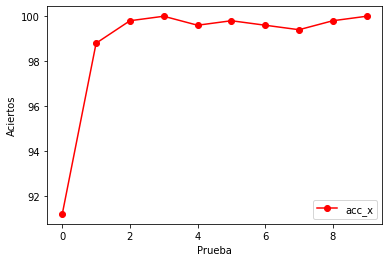

In [34]:
set_wilcoxon()

### Model and optimizers

Test [optimizer](https://keras.io/optimizers/) parameter with `sgd`, `adadelta` or `adam` values in order to check the final precision achieved.

In [ ]:
print(f'loss: {loss:.2f} acc: {acc:.2f}')

NameError: ignored

In [ ]:
print(model.summary())

Model: "sequential_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_150 (Conv2D)          (None, 28, 28, 6)         456       
_________________________________________________________________
activation_375 (Activation)  (None, 28, 28, 6)         0         
_________________________________________________________________
max_pooling2d_150 (MaxPoolin (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_151 (Conv2D)          (None, 10, 10, 16)        2416      
_________________________________________________________________
activation_376 (Activation)  (None, 10, 10, 16)        0         
_________________________________________________________________
max_pooling2d_151 (MaxPoolin (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_75 (Flatten)         (None, 400)             

## Prediction

### Testing AUC result for two and multiple classes

In [ ]:
y_scores = model.predict(X_test) # Confidence prediction per class
y_pred = y_scores.argmax(axis=1) # Select classes with most confidence prediction

if nb_classes ==  2:
  print(f'AUC {metrics.roc_auc_score(y_test, np.round(y_scores[:,1],2)):.4f} ')
else:
  print(f'AUC {metrics.roc_auc_score(y_test, y_scores, multi_class = "ovr"):.4f} ')

NameError: ignored

## More metrics about results

We can find more information about `precision`, `recall` and `f1` metrics in <https://en.wikipedia.org/wiki/Precision_and_recall>.

In [ ]:
print('Predictions', collections.Counter(y_pred),'\n')

print('Confusion matrix')
print(metrics.confusion_matrix(y_test,y_pred),'\n')

target_names = ['TUMOR', 'HEALTHY'] if nb_classes ==  2 else ['TUMOR','STROMA','COMPLEX','LYMPHO','DEBRIS','MUCOSA','ADIPOSE','EMPTY']

print(metrics.classification_report(y_test, y_pred, target_names=target_names))

NameError: ignored